In [102]:
import json
import pandas as pd
from math import sin, sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns


replace = {
    'm_fwd': 'Alpha Forward',
    'm_rev': 'Alpha Reverse',
    'm_swr': 'Alpha SWR',
    'm_freq': 'Alpha Frequency',
    'm_temp': 'Alpha Temperature',
    't_fwd': 'MC-200 Forward',
    't_rev': 'MC-200 Reverse',
    't_swr': 'MC-200 SWR',
}


def load_file(*files: str):
    data = {}
    for filename in files:
        with open(filename) as f:
            for line in f.readlines():
                if line.startswith('//'):
                    continue

                d = json.loads(line)

                # drop all the metadata and the raw sample values
                record = {
                    **d['location'],
                    # **d['data'],
                }

                def sim(a, b):
                    diff = (b - a)
                    return (diff / a) * 100

                record['error_fwd'] = sim(d['data']['m_fwd'], d['data']['t_fwd'])
                record['error_rev'] = sim(d['data']['m_rev'], d['data']['t_rev'])
                record['error_swr'] = sim(d['data']['m_swr'], d['data']['t_swr'])

                for k, v in replace.items():
                    record[v] = d['data'][k]

                location = d['location']
                key = f"{location['ant']}:{location['freq']}:{location['power']}"
                data[key] = record

    df = pd.DataFrame.from_records(list(data.values()))

    return df

freqs = [
    '01800000',
    '03500000',
    '07000000',
    '10100000',
    '14000000',
    '18068000',
    '21000000',
    '24890000',
    '28000000',
    '50000000',
]

In [125]:
df = load_file('data.jsonl')
df = df.query('ant == 1')
df = df.query('freq == "14000000"')
# df = df.query('freq == "18068000"')
# df = df.query('freq == "10100000"')
# df = df.query('freq == "01800000"')
# df = df.query('power == "020"')
# df = df.sort_values('error_swr', ascending=False)
df = df.sort_values(['ant', 'freq', 'power'])

df = df.filter(['ant', 'freq', 'power', 'error_fwd', 'MC-200 Forward', 'Alpha Forward', 'error_rev', 'MC-200 Reverse', 'Alpha Reverse', 'error_swr', 'MC-200 SWR', 'Alpha SWR'], axis=1)
df.style.format({
    'error_swr':'{:0.1f}%',
    'error_fwd':'{:0.1f}%',
    'error_rev':'{:0.1f}%',
    'MC-200 Forward':'{:0.2f}',
    'Alpha Forward':'{:0.2f}',
    'MC-200 Reverse':'{:0.3f}',
    'Alpha Reverse':'{:0.3f}',
    'MC-200 SWR':'{:0.2f}',
    'Alpha SWR':'{:0.2f}'
})


,ant,freq,power,error_fwd,MC-200 Forward,Alpha Forward,error_rev,MC-200 Reverse,Alpha Reverse,error_swr,MC-200 SWR,Alpha SWR
97,1,14000000,5,3.6%,5.04,4.87,25.5%,0.126,0.100,2.8%,1.38,1.34
99,1,14000000,10,-0.7%,10.78,10.86,31.2%,0.274,0.209,4.2%,1.38,1.32
101,1,14000000,15,-1.8%,14.77,15.04,33.7%,0.369,0.276,4.9%,1.38,1.31
96,1,14000000,20,2.5%,20.14,19.64,35.8%,0.495,0.365,4.6%,1.37,1.31
98,1,14000000,25,1.2%,26.42,26.10,30.3%,0.635,0.487,4.3%,1.37,1.31
100,1,14000000,30,2.6%,30.75,29.96,32.6%,0.729,0.550,4.5%,1.36,1.31
102,1,14000000,35,3.5%,36.36,35.12,28.2%,0.854,0.666,3.9%,1.36,1.31
103,1,14000000,40,3.8%,41.56,40.04,33.0%,0.979,0.736,4.3%,1.36,1.31
104,1,14000000,50,4.8%,54.97,52.43,31.0%,1.293,0.986,3.9%,1.36,1.31
105,1,14000000,60,5.2%,63.33,60.18,32.2%,1.498,1.133,4.0%,1.36,1.31


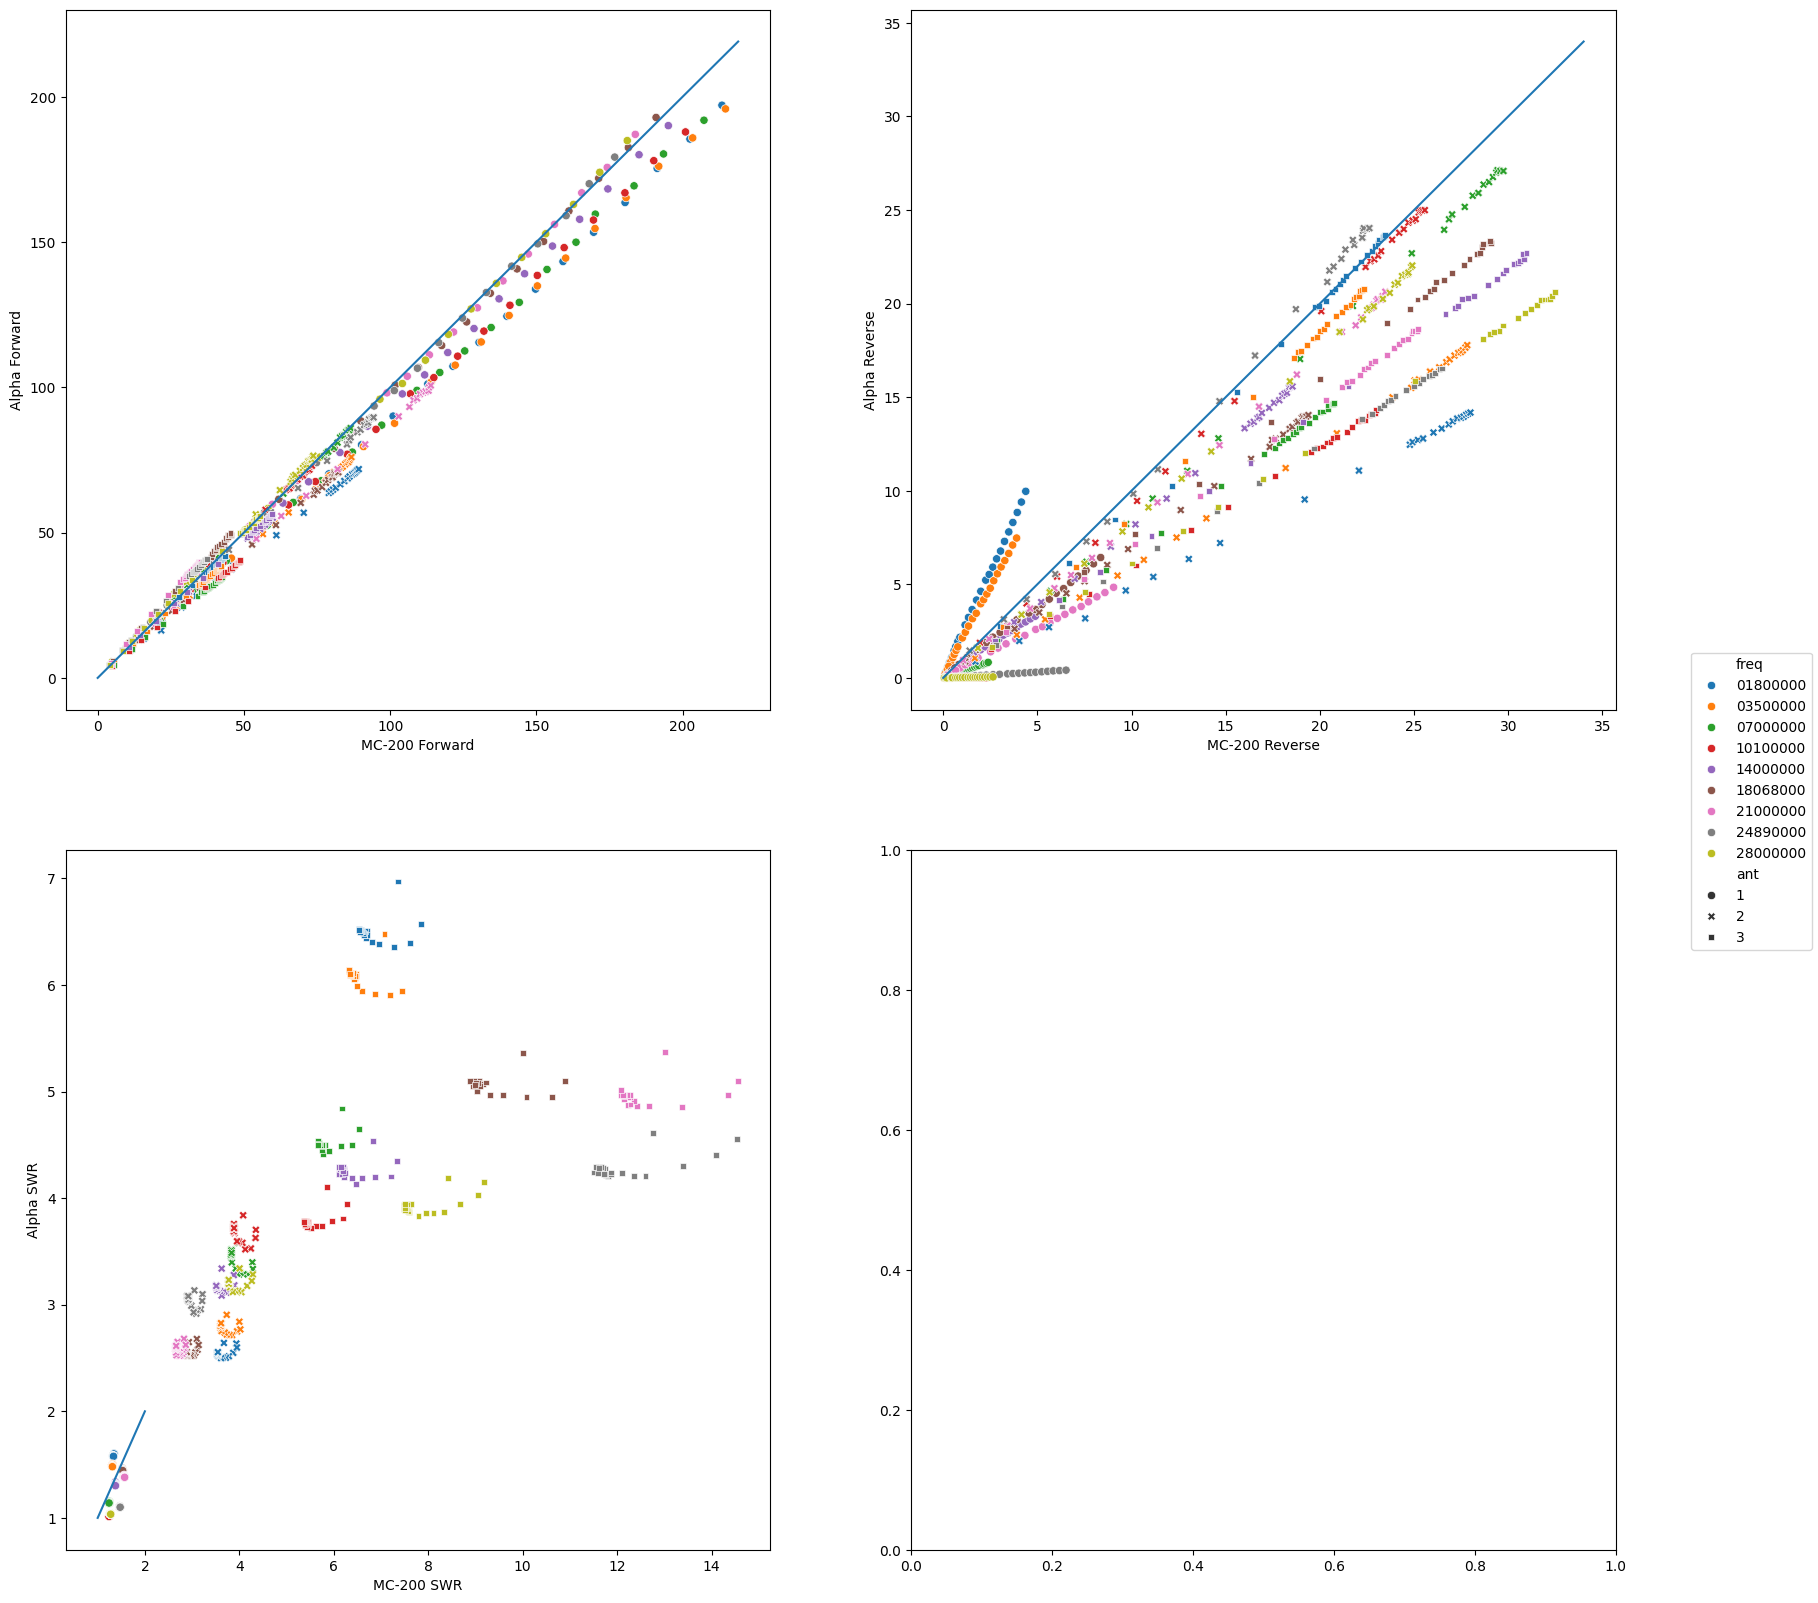

In [77]:
df = load_file('data.jsonl')

# df = df.query('ant == 1')
df = df.query('freq != "50000000"')

fig, ax = plt.subplots(2, 2, figsize=(20, 20))


def make_line(a, *r):
    line = pd.DataFrame.from_records([{'x': i, 'y': i} for i in range(*r)])
    sns.lineplot(line, x='x', y='y', ax=a)


sns.scatterplot(df, x='MC-200 Forward', y='Alpha Forward', hue='freq', style='ant', ax=ax[0, 0])
make_line(ax[0, 0], 220)

sns.scatterplot(df, x='MC-200 Reverse', y='Alpha Reverse', hue='freq', style='ant', ax=ax[0, 1])
make_line(ax[0, 1], 35)

sns.scatterplot(df, x='MC-200 SWR', y='Alpha SWR', hue='freq', style='ant', ax=ax[1, 0])
make_line(ax[1, 0], 1, 3)

handles, labels = ax[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right')

ax[0, 0].get_legend().remove()
ax[0, 1].get_legend().remove()
ax[1, 0].get_legend().remove()


In [ ]:
df = load_file('data.jsonl')
# df = df.query('ant == 3')
# df = df.query('freq == "14000000"')
# df = df.query('freq == "18068000"')
# df = df.query('freq == "10100000"')
# df = df.query('freq == "01800000"')
# df = df.query('power == "020"')
df = df.drop('Alpha Frequency', axis=1)
df = df.drop('Alpha Temperature', axis=1)
df['error_swr'] = df['error_swr'].apply(lambda x: f'{x:0.1f}%')
df['error_fwd'] = df['error_fwd'].apply(lambda x: f'{x:0.1f}%')
df['error_rev'] = df['error_rev'].apply(lambda x: f'{x:0.1f}%')
# df = df.sort_values('error_swr', ascending=False)
df = df.sort_values(['ant', 'freq', 'power'])

df = df.filter(['ant', 'freq', 'power', 'error_fwd', 'MC-200 Forward', 'Alpha Forward', 'error_rev', 'MC-200 Reverse', 'Alpha Reverse', 'error_swr', 'MC-200 SWR', 'Alpha SWR'], axis=1)

freqs = [
    '01800000',
    '03500000',
    '07000000',
    '10100000',
    '14000000',
    '18068000',
    '21000000',
    '24890000',
    '28000000',
    '50000000',
]
html = ''

for ant in [1, 2, 3]:
    outer = df.query(f'ant == {ant}')
    for freq in freqs:
        inner = outer.query(f'freq == "{freq}"')
        html += inner.to_html(index=False)

with open('table.html', 'w') as f:
    f.write(html)
